In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from string import ascii_lowercase
import requests
import random

In [2]:
# get list of words
words = requests.get(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
    ).text.splitlines()
print(f'{len(words)=}')
print(f'{words[:5]=}')

len(words)=32033
words[:5]=['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# integer mappings of characters
chars = ascii_lowercase
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# total characters (possible prediction outcomes)
vocab_size = len(itos)
# number of previous characters to consider for prediction
block_size = 3
# dimensionality of character embedding vectors
n_embed = 10
# number of neurons in the hidden layer
n_hidden = 200

In [5]:
# build dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# use build_dataset for train/val/test splits
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# training, val, and testing dataset sizes
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# utility function for comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

# initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # (1.0 / counts_sum) can cause float underflow in backprop
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3547, grad_fn=<NegBackward0>)

Let's reverse engineer what's happening above.

In [10]:
# batch size, n_out
logprobs.shape

torch.Size([32, 27])

In [11]:
# integer correct values
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [12]:
# takes the Yb index from each tensor row in logprobs (log likelihood tensor)
logprobs[range(n), Yb]

tensor([-3.9353, -3.1017, -3.5217, -3.2718, -4.1608, -3.4524, -3.1159, -4.0772,
        -3.2167, -4.2967, -3.1198, -1.6958, -2.8571, -3.0219, -3.1474, -3.2456,
        -3.8907, -3.0126, -3.5330, -3.3922, -2.8766, -3.0110, -4.3382, -4.0328,
        -3.4742, -2.8382, -2.9934, -4.0247, -2.8231, -3.4338, -3.3754, -3.0619],
       grad_fn=<IndexBackward0>)

In [13]:
# negative average log likelihood (loss)
-logprobs[range(n), Yb].mean()

tensor(3.3547, grad_fn=<NegBackward0>)

$$ \text{loss} = - \Sigma \frac{1}{n} x_i $$
$$ \frac{dloss}{dx_i} = -\frac{1}{n} $$

This is only the case for the logprobs that actually contribute to the outcome (i.e. the correct predictions). The derivatives/gradients of all non-contributing values in the tensor are zero, since they do not contribute.

In [15]:
# prepare logprobs derivative
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
# view
print(dlogprobs[:3])
# compare hand calculation to actual (pytorch-calculated) logprobs gradient
cmp('logprobs', dlogprobs, logprobs)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]])
logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


$$ \text{logprobs} = log(probs) $$
$$ \frac{dprobs}{dlogprobs} = \frac{1}{probs} * dlogprobs $$

In [16]:
# prepare probabilities derivative
dprobs = (1.0 / probs) * dlogprobs
# view
print(dprobs[:3])
# compare
cmp('probs', dprobs, probs)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -1.5993,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.6949,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0576,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]], grad_fn=<SliceBackward0>)
probs           | exact: True  | approximate: True  | maxdiff: 0.0


The next step is more involved. Starting with `probs = counts * counts_sum_inv`, the derivative of probs with respect to counts_sum_inv would just be counts. But we need to be careful, since the shapes of the two tensors are not the same!

In [17]:
print(counts.shape)
print(counts_sum_inv.shape)

torch.Size([32, 27])
torch.Size([32, 1])


Ultimately, we want the derivative to be of the same shape as the counts_sum_inv, so we'll have to collapse the counts in a way that is consistent with derivatives.

This is a situation similar to a node used multiple times in micrograd: the backpropagated gradients must be summed. So, we need to do an element-wise multiplication of counts by dprobs, then sum them horizontally to get a column tensor of the same shape as counts_sum_inv.

In [18]:
# prepare derivative
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)
# view
print(dcounts_sum_inv[:3])
# confirm shape match
print(dcounts_sum_inv.shape)
# compare
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

tensor([[-0.3745],
        [-0.3189],
        [-0.2719]], grad_fn=<SliceBackward0>)
torch.Size([32, 1])
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


Now we need to prepare the derivative of counts. This is the same as above, but rather than collapsing a tensor, we need to broadcast it. Fortunately, torch can do this for us automatically (still, we need to be careful with our broadcasting rules!)

In [20]:
# prepare derivative
dcounts = counts_sum_inv * dprobs
# view
print(dcounts[:3])
# confirm shape match
print(dcounts.shape)
# compare
cmp('counts', dcounts, counts)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.1335,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0681,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1215,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]], grad_fn=<SliceBackward0>)
torch.Size([32, 27])
counts          | exact: False | approximate: False | maxdiff: 0.005733147729188204


Our comparison is false because there's another part of this "branch" of derivatives: `counts_sum`. We need to pass the derivatives through this, and back to counts, before we can make a true comparison.

In [21]:
# prepare derivative
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
# view
print(dcounts_sum[:3])
# compare
cmp('counts_sum', dcounts_sum, counts_sum)

tensor([[0.0026],
        [0.0031],
        [0.0036]], grad_fn=<SliceBackward0>)
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


Again, we have a shape problem.

In [22]:
print(counts.shape)
print(counts_sum.shape)

torch.Size([32, 27])
torch.Size([32, 1])


There's some linear algebra magic that I don't fully understand here. Something about all other elements being 1 except those in the current derivative row, which are zero.

Additionally (pun intended) we have already calculated `dcounts`, so we need to add this other gradient to what we already have.

In [23]:
# prepare derivative
dcounts += torch.ones_like(counts) * dcounts_sum
# view
print(dcounts[:3])
# confirm shape match
print(dcounts.shape)
# compare
cmp('counts', dcounts, counts)

tensor([[ 0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,
         -0.1308,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,
          0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,  0.0026,
          0.0026,  0.0026,  0.0026],
        [ 0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
          0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031, -0.0650,  0.0031,
          0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,  0.0031,
          0.0031,  0.0031,  0.0031],
        [ 0.0036,  0.0036,  0.0036,  0.0036,  0.0036,  0.0036,  0.0036,  0.0036,
          0.0036,  0.0036,  0.0036,  0.0036,  0.0036,  0.0036,  0.0036, -0.1179,
          0.0036,  0.0036,  0.0036,  0.0036,  0.0036,  0.0036,  0.0036,  0.0036,
          0.0036,  0.0036,  0.0036]], grad_fn=<SliceBackward0>)
torch.Size([32, 27])
counts          | exact: True  | approximate: True  | maxdiff: 0.0


An easy derivative here - the derivative of exponentiation is itself!

In [24]:
# prepare derivative
dnorm_logits = counts * dcounts # .exp() is the derivative of itself
# view
print(dnorm_logits[:3])
# compare
cmp('norm_logits', dnorm_logits, norm_logits)



tensor([[ 0.0021,  0.0026,  0.0006,  0.0015,  0.0006,  0.0025,  0.0008,  0.0012,
         -0.0306,  0.0010,  0.0012,  0.0011,  0.0011,  0.0009,  0.0011,  0.0004,
          0.0003,  0.0006,  0.0005,  0.0018,  0.0015,  0.0007,  0.0008,  0.0022,
          0.0020,  0.0008,  0.0006],
        [ 0.0017,  0.0016,  0.0031,  0.0016,  0.0013,  0.0011,  0.0006,  0.0015,
          0.0006,  0.0008,  0.0017,  0.0013,  0.0013,  0.0008, -0.0298,  0.0012,
          0.0009,  0.0005,  0.0007,  0.0012,  0.0006,  0.0006,  0.0005,  0.0020,
          0.0008,  0.0011,  0.0008],
        [ 0.0006,  0.0007,  0.0005,  0.0004,  0.0008,  0.0013,  0.0017,  0.0020,
          0.0020,  0.0009,  0.0007,  0.0010,  0.0012,  0.0014,  0.0007, -0.0303,
          0.0005,  0.0011,  0.0009,  0.0036,  0.0021,  0.0011,  0.0011,  0.0013,
          0.0012,  0.0006,  0.0009]], grad_fn=<SliceBackward0>)
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


Back to more wonky shape nonsense. I don't really understand this one either, so I'll just have to roll with it.

This is another "branching" situation - we must calculate `dlogit_maxes` first, then follow up with `dlogits`.

In [25]:
print(norm_logits.shape)
print(logits.shape)
print(logit_maxes.shape)

torch.Size([32, 27])
torch.Size([32, 27])
torch.Size([32, 1])


In [27]:
# prepare derivative
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(dim=1, keepdim=True)
# view
print(dlogit_maxes[:3])
# confirm shape match
print(dlogit_maxes.shape)
# compare
cmp('logit_maxes', dlogit_maxes, logit_maxes)

tensor([[-3.2596e-09],
        [-4.6566e-10],
        [-1.8626e-09]], grad_fn=<SliceBackward0>)
torch.Size([32, 1])
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


Those `dlogit_maxes` values are very small, which makes sense - the maximum value that is subtracted from all elements should have no impact on the gradient. In other words, all of these values should be zero!

More broadcasting black magic, although I feel like I could understand this one if I had the brainpower to think about it right now.

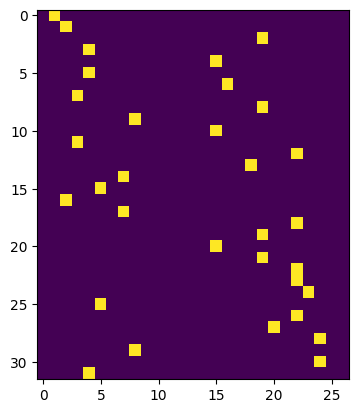

In [28]:
# one-hot tensor of logits indices
temp = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])
plt.imshow(temp);

In [29]:
# prepare / update derivative
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
# compare
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


We're out of the custom cross_entropy function. Now into the actual weights and biases!

In [30]:
print(dlogits.shape)
print(h.shape)
print(W2.shape)
print(b2.shape)

torch.Size([32, 27])
torch.Size([32, 64])
torch.Size([64, 27])
torch.Size([27])


There's some weedy matrix multiplication to justify the following derivatives, so I'm just going to write the derivatives here.

In [31]:
# prepare derivatives
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(dim=0)
# compare
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


Another easy one: derivative of tanh.

In [32]:
# prepare derivative
dhpreact = (1.0 - h**2) * dh
# compare
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: True  | approximate: True  | maxdiff: 0.0


Moving onto the batchnorm gain and bias.

In [33]:
print(hpreact.shape)
print(bngain.shape)
print(bnraw.shape)
print(bnbias.shape)

torch.Size([32, 64])
torch.Size([1, 64])
torch.Size([32, 64])
torch.Size([1, 64])


In [34]:
# prepare derivatives
dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(dim=0, keepdim=True)
# compare
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)

bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0


In [ ]:
# prepare derivatives